## Amazon SageMaker DICOM Training Overview

In this example we will demonstrate how to integrate the [MONAI](http://monai.io) framework into Amazon SageMaker, use SageMaker Ground Truth labelled data, and give example code of MONAI pre-processing transforms and neural network (DenseNet) that you can use to train a medical image classification model using DICOM images directly.  Please also visit [Build a medical image analysis pipeline on Amazon SageMaker using the MONAI framework](https://aws.amazon.com/blogs/industries/build-a-medical-image-analysis-pipeline-on-amazon-sagemaker-using-the-monai-framework/) for additional details on how to deploy the MONAI model, pipe input data from S3, and perform batch inferences using SageMaker batch transform.

For more information about the PyTorch in SageMaker, please visit [sagemaker-pytorch-containers](https://github.com/aws/sagemaker-pytorch-containers) and [sagemaker-python-sdk](https://github.com/aws/sagemaker-python-sdk) github repositories.

Sample dataset is obtained from this [source COVID-CT-MD](https://github.com/ShahinSHH/COVID-CT-MD). The dataset contains volumetric chest CT scans (DICOM files) of 169 patients positive for COVID-19 infection, 60 patients with CAP (Community Acquired Pneumonia), and 76 normal patients. 

In [1]:
# Copyright 2021 Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: MIT-0

!pip install -r ./source/requirements.txt
!mkdir -p data

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [ ]:
bucket_path

In [ ]:
import os
from pathlib import Path
from dotenv import load_dotenv
env_path = Path('.') / 'set.env'
load_dotenv(dotenv_path=env_path)

bucket="dataset-pathology"
bucket_path=os.environ.get('BUCKET_PATH')
user=os.environ.get('DICOM_USER')
password = os.environ.get('DICOM_PASSWORD')

print('Bucket: '+bucket)
#print('Bucket Prefix: '+bucket_path)
#print('User: '+str(user))
print('Password: '+str(password))

In [ ]:
iam=

## Training Dataset in S3

In [ ]:
from sagemaker.s3 import S3Downloader, S3Uploader
bucket="s3://dataset-pathology"
key='CovidTrainingV2'
path=os.path.join(bucket,key)
file_list=S3Downloader.download(path,local_path='./data') ## all the DICOM files for model training

## Amazon SageMaker GroundTruth Labeling Metadata

Download and parse the GroundTruth JSON annotation file for labelled data, classes and DICOM image URLs. 

In [ ]:
import json
import boto3
s3 = boto3.client('s3')

image_url_list = []
image_label_list = []


In [ ]:
# Get SageMaker GroundTruth labeling data from annotation file manifest.json

datadir = './data'
metadata = datadir+'/manifest.json'

## DICOM Upload Files to S3

Download the DICOM files from Orthanc DICOM Server into S3 for SageMaker training.

You may skip the step if the data is already saved in S3

In [5]:
import urllib3
import requests
import os
from io import BytesIO
import contextlib;
urllib3.disable_warnings()

In [ ]:
import urllib3
import requests
import os
from io import BytesIO
import contextlib;
urllib3.disable_warnings()

image_file_list = []

#Load DICOM images to S3
for i, j in enumerate(image_url_list):
    file_name = image_url_list[i].split("/file")[0].split("instances/")[1] + '.dcm'
    response = requests.get(image_url_list[i], auth=(user, password), stream=True, verify=False)
    fp = BytesIO(response.content)
    s3.upload_fileobj(fp, bucket, file_name)   
    image_file_list.append(file_name)

## DICOM Display Sample Set

Download a sample of DICOM images from the S3 bucket and display with label from annotation file.

In [6]:
os.getcwd()

'/home/ec2-user/SageMaker/repo'

In [7]:
datadir='./data'
image_file_list=os.listdir(datadir)

In [ ]:
os.listdir(datadir)

In [ ]:
import monai
from monai.transforms import Compose, LoadImage, Resize, ScaleIntensity, ToTensor, SqueezeDim,RandRotate,RandFlip,RandZoom
import matplotlib.pyplot as plt


In [ ]:
len(image_file_list)

In [ ]:
## preprocess the dataset before trainining using MONAI.  based on img.shape, this is a channel last image
train_transforms = Compose([
    LoadImage(image_only=True),
    ScaleIntensity(),
    RandRotate(range_x=15, prob=0.5, keep_size=True),
    RandFlip(spatial_axis=0, prob=0.5),
    #RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5, keep_size=True),
    Resize(spatial_size=(512,-1)),
    ToTensor()
])
img = train_transforms(datadir+'/'+image_file_list[0])
img.shape ## check image size after preprocessing

In [ ]:
datadir

(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)


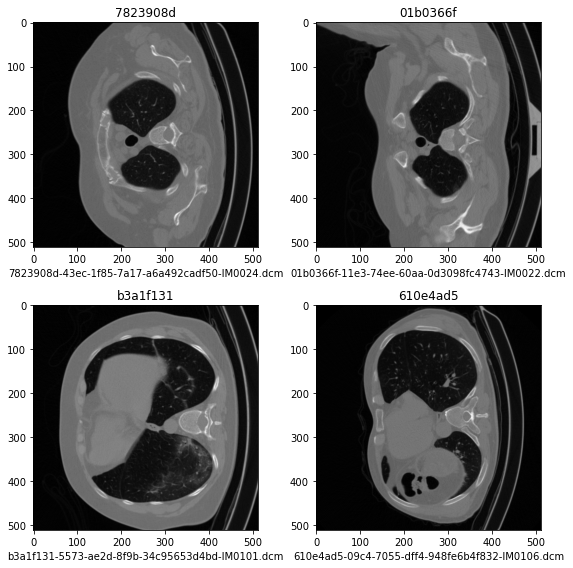

In [8]:
import monai
from monai.transforms import Compose, LoadImage, Resize, ScaleIntensity, ToTensor, SqueezeDim
import matplotlib.pyplot as plt

#Display sample of DICOM Images
inf_test = []
inf_test_label = []

trans = Compose([LoadImage(image_only=True), Resize(spatial_size=(512,-1))])
plt.subplots(2, 2, figsize=(8, 8))
for i in range(0,4):
    #s3.download_file(bucket, image_file_list[i], datadir+'/'+image_file_list[i])
    
    img = trans(datadir+'/'+image_file_list[i])
    print(img.shape)
    plt.subplot(2, 2, i + 1)
    plt.xlabel(image_file_list[i])
    plt.imshow(img, cmap='gray')
    plt.title(image_file_list[i].split('-')[0])
    inf_test.append(datadir+'/'+image_file_list[i])
    inf_test_label.append(image_file_list[i].split('-')[0])
    
plt.tight_layout()
plt.show()

## Data

### Create Sagemaker session and S3 location for DICOM dataset

In [17]:
import sagemaker

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
inputs='s3://dataset-pathology/CovidTrainingV2'

## IF WE UPLOAD THE DATA TO S3, DO THE FOLLOWING STEP
#inputs = sagemaker_session.upload_data(path=datadir, bucket=bucket)
print('input spec as an S3 path: {}'.format(inputs))

input spec as an S3 path: s3://dataset-pathology/CovidTrainingV2


## Train Model
### Training

The ```monai_dicom.py``` script provides all the code we need for training and hosting a SageMaker model (model_fn function to load a model). The training script is very similar to a training script you might run outside of SageMaker, but you can access useful properties about the training environment through various environment variables, such as:

* SM_MODEL_DIR: A string representing the path to the directory to write model artifacts to. These artifacts are uploaded to S3 for model hosting.
* SM_NUM_GPUS: The number of gpus available in the current container.
* SM_CURRENT_HOST: The name of the current container on the container network.
* SM_HOSTS: JSON encoded list containing all the hosts .
Supposing one input channel, 'training', was used in the call to the PyTorch estimator's fit() method, the following will be set, following the format SM_CHANNEL_[channel_name]:

* SM_CHANNEL_TRAINING: A string representing the path to the directory containing data in the 'training' channel.
For more information about training environment variables, please visit [SageMaker Containers](https://github.com/aws/sagemaker-containers).

A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to model_dir so that it can be hosted later. Hyperparameters are passed to your script as arguments and can be retrieved with an argparse.ArgumentParser instance.

In [ ]:
!pygmentize source/monai_dicom.py

## Run training in SageMaker

The `PyTorch` class allows us to run our training function as a training job on SageMaker infrastructure.  We need to configure it with our training script, an IAM role, the number of training instances, the training instance type, and hyperparameters.  In this case we are going to run our training job on ```ml.m5.xlarge``` instance.  But this example can be ran on one or multiple, cpu or gpu instances ([full list of available instances](https://aws.amazon.com/sagemaker/pricing/instance-types/)).  The hyperparameters parameter is a dict of values that will be passed to your training script -- you can see how to access these values in the ```monai_dicom.py``` script above.

In [50]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point='monai_dicom_json.py',
                    source_dir='source',
                    role=role,
                    framework_version='1.5.0',
                    py_version='py3',
                    instance_count=1,
                    instance_type='ml.m5.2xlarge',
                    hyperparameters={
                        'backend': 'gloo',
                        'epochs': 10
                    })

After we've constructed our PyTorch object, we can fit it using the DICOM dataset we uploaded to S3.

In [51]:
%time
estimator.fit({'train': inputs})

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
2022-01-25 07:33:08 Starting - Starting the training job...
2022-01-25 07:33:11 Starting - Launching requested ML instancesProfilerReport-1643095988: InProgress
......
2022-01-25 07:34:30 Starting - Preparing the instances for training.........
2022-01-25 07:36:11 Downloading - Downloading input data...
2022-01-25 07:36:39 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-25 07:36:39,810 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-25 07:36:39,824 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-01-25 07:36:39,834 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-25 07:36:39,838 sagemaker_pytorch_container.training INFO     Invoking user training scr

1/0, train_loss: 1.1249
epoch 1 average loss: 1.1249
----------
epoch 2/10
inputs shape is ----- torch.Size([25, 512, 512, 1])
inputs shape after is ----- torch.Size([25, 1, 512, 512])
1/0, train_loss: 1.1087
epoch 2 average loss: 1.1087
----------
epoch 3/10
inputs shape is ----- torch.Size([25, 512, 512, 1])
inputs shape after is ----- torch.Size([25, 1, 512, 512])
1/0, train_loss: 1.0961
epoch 3 average loss: 1.0961
----------
epoch 4/10
inputs shape is ----- torch.Size([25, 512, 512, 1])
inputs shape after is ----- torch.Size([25, 1, 512, 512])
1/0, train_loss: 1.0756
epoch 4 average loss: 1.0756
----------
epoch 5/10
inputs shape is ----- torch.Size([25, 512, 512, 1])
inputs shape after is ----- torch.Size([25, 1, 512, 512])
1/0, train_loss: 1.0612
epoch 5 average loss: 1.0612
----------
epoch 6/10
inputs shape is ----- torch.Size([25, 512, 512, 1])
inputs shape after is ----- torch.Size([25, 1, 512, 512])
1/0, train_loss: 1.0597
epoch 6 average loss: 1.0597
----------
epoch 7/10


In [52]:
## Conduct Prediction here 

predictor1 = estimator.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

-------!

In [54]:
inputs = val_data[0].permute(0,3, 2, 1)
response = predictor1.predict(inputs)
response

array([[-0.15932162,  0.11234466, -0.01858233]])

In [ ]:
predictor1 = estimator.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

In [162]:
from source.monai_dicom import DICOMDataset
import torch

def get_val_data_loader(valX, valY):
    val_transforms = Compose([
    LoadImage(image_only=True),
    ScaleIntensity(),
    Resize(spatial_size=(512,-1)),
    ToTensor()
    ])
    
    dataset = DICOMDataset(valX, valY, val_transforms)
    return torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=1)

In [165]:
inf_test_label

['7823908d', '01b0366f', 'b3a1f131', '610e4ad5']

In [160]:
val_loader = get_val_data_loader(inf_test[1:4], inf_test_label[1:4])

In [167]:
class_names = [ "Normal","Cap", "Covid",]
for i, val_data in enumerate(val_loader):
    
    inputs = val_data[0].permute(0,3, 2, 1)
    
    input2 = val_data[1]
    print(input2)

('01b0366f',)
('b3a1f131',)
('610e4ad5',)


In [161]:
class_names = [ "Normal","Cap", "Covid",]
for i, val_data in enumerate(val_loader):
    
    inputs = val_data[0].permute(0,3, 2, 1)
    response = predictor1.predict(inputs)
    pred = torch.nn.functional.softmax(torch.tensor(response), dim=1)
    
    ## convert it to json format 
    
    
    
    top_p, top_class = torch.topk(pred, 1)
    actual_label = val_data[1]
    print('actual class is ', val_data[1])
    
    print("predicted probability: ", pred)
    print('predicted class: '+class_names[top_class])
    print('predicted class probablity: '+str(round(top_p.item(),2)))
    
    #x={"results":{"class":top_class.item(), "probability":round(top_p.item(),2)}}
    #print(x)

ValidationError: An error occurred (ValidationError) when calling the InvokeEndpoint operation: Endpoint pytorch-training-2022-01-25-07-43-01-073 of account 707754867495 not found.

In [ ]:
json.dumps(x)

## use a transform to wrap the input 

In [245]:
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import NumpySerializer


predictor2 = estimator.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge',entry_point='inference.py',source_dir='source',
                            serializer=sagemaker.serializers.JSONSerializer(),
    deserializer=sagemaker.deserializers.JSONDeserializer())

-------!

In [246]:
x1={"bucket": "dataset-pathology",
    "key":"CovidTrainingV2/cbe54c28-a36b-1e87-89dc-68ceaf517df1-IM0077.dcm",
    "label":"cap"}

In [247]:
predictor2.predict(x1)

{'results': {'class': 1, 'probability': 0.36}}

In [124]:
x=json.loads(y)
x['file']

'abcd.txt'

In [ ]:
predictor.serializer

In [ ]:
inf_test[:4]

for i in inf_test:
    

In [ ]:
inf_test_label[1:4]

In [ ]:
json.dumps(inf_test_label)

In [ ]:
import pandas as pd
x=pd.DataFrame({'file':inf_test, 'label':'neg'})
x.head()

In [ ]:
y=x.to_json(orient="columns")
parsed = json.loads(y)

In [ ]:
serialized_input_data=parsed

In [ ]:
pairs = parsed['file']
for key, value in pairs.items():

    print(value)



In [ ]:
for i, val_data in enumerate(val_loader):
    print("input_fn:",val_data)
            #inputs = val_data[0].permute(0,3, 2, 1)

In [ ]:
from source.inference import DICOMDataset
import torch

    
def get_val_data_loader(valX):
    val_transforms = Compose([
    LoadImage(image_only=True),
    ScaleIntensity(),
    Resize(spatial_size=(512,-1)),
    ToTensor()
    ])
    
    dataset = DICOMDataset(valX, val_transforms)
    return torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=1)

In [ ]:
from sagemaker.pytorch import PyTorchModel

# Create SageMaker model and deploy an endpoint
sm_pytorch_compiled_model = PyTorchModel(
    model_data='insert S3 path of compiled PyTorch model archive',
    role='AmazonSageMaker-ExecutionRole',
    entry_point='inference.py',
    source_dir='code',
    framework_version='1.5',
    py_version='py3',
    image_uri='insert appropriate ECR Image URI for PyTorch',
)

# Replace the example instance_type below to your preferred instance_type
predictor = sm_pytorch_compiled_model.deploy(initial_instance_count = 1, instance_type = 'ml.p3.2xlarge')

# Print the name of newly created endpoint
print(predictor.endpoint_name)    

In [39]:
model_data='s3://sagemaker-us-east-1-707754867495/pytorch-training-2022-01-24-08-21-55-339/source/sourcedir.tar.gz'

In [41]:
from sagemaker.pytorch import PyTorchModel

model = PyTorchModel(
    entry_point="inference.py",
    source_dir="source",
    role=role,
    model_data=model_data,
    framework_version="1.5.0",
    py_version="py3",
)
predictor = model.deploy(initial_instance_count = 1, instance_type = 'ml.m4.2xlarge',serializer=JSONSerializer,deserializer=deserializer)

----------!

In [26]:
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import NumpySerializer, JSONSerializer

deserializer=JSONDeserializer
serializer=JSONSerializer

predictor = model.deploy(initial_instance_count = 1, instance_type = 'ml.m4.2xlarge')#,serializer=JSONSerializer,deserializer=deserializer)


----------!

In [27]:
inf_test[0]

'./data/7823908d-43ec-1f85-7a17-a6a492cadf50-IM0024.dcm'

-----------!

In [94]:
import source.inference as inference

In [77]:
get_val_data_loader(x,"y")

In [101]:
from importlib import reload 

In [103]:
reload(inference)


<module 'source.inference' from '/home/ec2-user/SageMaker/repo/source/inference.py'>

In [168]:
from source.inference import DICOMDataset
import torch

    
def get_val_data_loader(valX):
    val_transforms = Compose([
    LoadImage(image_only=True),
    ScaleIntensity(),
    Resize(spatial_size=(512,-1)),
    ToTensor()
    ])
    
    dataset = DICOMDataset(valX, val_transforms)
    return torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=1)

def input_fn(serialized_input_data, content_type):
    #logger.info(f"Received request of type:{content_type}")
    
    print("serialized_input_data is---", serialized_input_data)
    if content_type == 'application/json':
        inputs=str(serialized_input_data['file'])
        print("inputs for DICOM file is:" , inputs) 
        label=serialized_input_data['label']
             
        val_loader = get_val_data_loader(inputs,label)
        for i, val_data in enumerate(val_loader):
            print("input_fn:",val_data.shape)


# Debugging here 

we need a list of files, instead of a single file ['file']

In [183]:
from source.inference import  DICOMDataset 
def get_val_data_loader(valX,ValY):
    val_transforms = Compose([
    LoadImage(image_only=True),
    ScaleIntensity(),
    Resize(spatial_size=(512,-1)),
    ToTensor()
    ])
    ValY
    dataset = DICOMDataset(valX,ValY, val_transforms)
    return torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=1)


def input_fn(serialized_input_data, content_type):
    #logger.info(f"Received request of type:{content_type}")
    
    print("serialized_input_data is---", serialized_input_data)
    if content_type == 'application/json':
        inputs=serialized_input_data['file']
        label=serialized_input_data['label']
        print("loaded label is:" , label)
        print("inputs is:" , inputs)      
        val_loader = get_val_data_loader(inputs,label)
        for i, val_data in enumerate(val_loader):
            print("input_fn:",i)
            inputs = val_data[0].permute(0,3, 2, 1)
            return inputs

    else:
        raise Exception('Requested unsupported ContentType in Accept: ' + content_type)
        return

In [206]:
input_fn(serialized_input_data,'application/json' )

serialized_input_data is--- {'file': ['./data/7823908d-43ec-1f85-7a17-a6a492cadf50-IM0024.dcm', './data/01b0366f-11e3-74ee-60aa-0d3098fc4743-IM0022.dcm', './data/b3a1f131-5573-ae2d-8f9b-34c95653d4bd-IM0101.dcm', './data/610e4ad5-09c4-7055-dff4-948fe6b4f832-IM0106.dcm'], 'label': ['neg', 'neg', 'neg', 'neg']}
loaded label is: ['neg', 'neg', 'neg', 'neg']
inputs is: ['./data/7823908d-43ec-1f85-7a17-a6a492cadf50-IM0024.dcm', './data/01b0366f-11e3-74ee-60aa-0d3098fc4743-IM0022.dcm', './data/b3a1f131-5573-ae2d-8f9b-34c95653d4bd-IM0101.dcm', './data/610e4ad5-09c4-7055-dff4-948fe6b4f832-IM0106.dcm']
input_fn: 0


tensor([[[[0.0099, 0.0142, 0.0095,  ..., 0.0060, 0.0069, 0.0117],
          [0.0069, 0.0151, 0.0104,  ..., 0.0082, 0.0117, 0.0181],
          [0.0056, 0.0134, 0.0125,  ..., 0.0017, 0.0134, 0.0220],
          ...,
          [0.0017, 0.0073, 0.0134,  ..., 0.0000, 0.0000, 0.0000],
          [0.0181, 0.0151, 0.0194,  ..., 0.0173, 0.0151, 0.0000],
          [0.0095, 0.0078, 0.0173,  ..., 0.0099, 0.0186, 0.0194]]]])

In [224]:
serialized_input_data['file']

['./data/7823908d-43ec-1f85-7a17-a6a492cadf50-IM0024.dcm',
 './data/01b0366f-11e3-74ee-60aa-0d3098fc4743-IM0022.dcm',
 './data/b3a1f131-5573-ae2d-8f9b-34c95653d4bd-IM0101.dcm',
 './data/610e4ad5-09c4-7055-dff4-948fe6b4f832-IM0106.dcm']

In [225]:
predictor2.predict(serialized_input_data)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (500) from primary with message "string indices must be integers
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/sagemaker_inference/transformer.py", line 126, in transform
    result = self._transform_fn(self._model, input_data, content_type, accept)
  File "/opt/conda/lib/python3.6/site-packages/sagemaker_inference/transformer.py", line 215, in _default_transform_fn
    data = self._input_fn(input_data, content_type)
  File "/opt/ml/model/code/inference.py", line 83, in input_fn
    inputs=serialized_input_data['file']
TypeError: string indices must be integers
". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-training-2022-01-25-09-25-37-278 in account 707754867495 for more information.

### support images saved in S3 


In [ ]:
serialized_input_data['file']

In [207]:
from sagemaker.s3 import S3Downloader, S3Uploader
bucket="s3://dataset-pathology"
key='CovidTrainingV2'
path=os.path.join(bucket,key)
file_list=S3Downloader.list(path) ## al

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f54dbfec0b8>>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/multiprocessing/connection.py", line 911,

In [235]:
#bucket:
file_list[0].split('/')

['s3:',
 '',
 'dataset-pathology',
 'CovidTrainingV2',
 '01b0366f-11e3-74ee-60aa-0d3098fc4743-IM0022.dcm']

In [ ]:
key
file_list[0].split('/')[2:]

In [210]:
class S3ObjectSpec:
    """Utility class for parsing an S3 location spec from a JSON-able dict"""

    def __init__(self, spec: dict):
        if "URI" in spec:
            if not spec["URI"].lower().startswith("s3://"):
                raise ValueError("URI must be a valid 's3://...' URI if provided")
            bucket, _, key = spec["URI"][len("s3://") :].partition("/")
        else:
            bucket = spec.get("Bucket")
            key = spec.get("Key")
        if not (bucket and key and isinstance(bucket, str) and isinstance(key, str)):
            raise ValueError(
                "Must provide an object with either 'URI' or 'Bucket' and 'Key' properties. "
                f"Parsed bucket={bucket}, key={key}"
            )
        self.bucket = bucket
        self.key = key



In [217]:
bucket='dataset-pathology'
key='CovidTrainingV2/01b0366f-11e3-74ee-60aa-0d3098fc4743-IM0022.dcm'

In [219]:
import boto3
s3client = boto3.client("s3")



s3client.get_object(Bucket=bucket, Key=key)["Body"]

In [ ]:
from source.inference import  DICOMDataset 
def get_val_data_loader(valX,ValY):
    val_transforms = Compose([
    LoadImage(image_only=True),
    ScaleIntensity(),
    Resize(spatial_size=(512,-1)),
    ToTensor()
    ])
    ValY
    dataset = DICOMDataset(valX,ValY, val_transforms)
    return torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=1)


def input_fn(serialized_input_data, content_type):
    #logger.info(f"Received request of type:{content_type}")
    
    print("serialized_input_data is---", serialized_input_data)
    if content_type == 'application/json':
        s3_input = req_json.get("S3Input")
        if s3_input:
            try:
                s3_input = S3ObjectSpec(s3_input)
            except ValueError as e:
                raise ValueError(
                    "Invalid Request.S3Input: If provided, must be an object with 'URI' or 'Bucket' "
                    "and 'Key'"
                ) from e
            logger.info(f"Fetching S3Input from s3://{s3_input.bucket}/{s3_input.key}")
            doc_json = json.loads(
                s3client.get_object(Bucket=s3_input.bucket, Key=s3_input.key)["Body"].read()
            )

        
        inputs=serialized_input_data['file']
        label=serialized_input_data['label']
        print("loaded label is:" , label)
        print("inputs is:" , inputs)      
        val_loader = get_val_data_loader(inputs,label)
        for i, val_data in enumerate(val_loader):
            print("input_fn:",i)
            inputs = val_data[0].permute(0,3, 2, 1)
            return inputs

    else:
        raise Exception('Requested unsupported ContentType in Accept: ' + content_type)
        return

In [ ]:
serialized_input_data={
"file":[file_list[0]],
"label":["dummy"]
}

In [203]:
inputs=serialized_input_data['file']
label=serialized_input_data['label']

In [229]:
inputs[0]='s3://dataset-pathology/CovidTrainingV2/cbe54c28-a36b-1e87-89dc-68ceaf517df1-IM0077.dcm'
serialized_input_data['file']=inputs

def input_fn(serialized_input_data, content_type='application/json'):
    #logger.info(f"Received request of type:{content_type}")
    
    print("serialized_input_data is---", serialized_input_data)
    if content_type == 'application/json':
        inputs=serialized_input_data['file']
        label=serialized_input_data['label']
        print("loaded label is:" , label)
        print("inputs is:" , inputs)      
        val_loader = get_val_data_loader(inputs,label)
        for i, val_data in enumerate(val_loader):
            print("input_fn:",i)
            inputs = val_data[0].permute(0,3, 2, 1)
            return inputs

    else:
        raise Exception('Requested unsupported ContentType in Accept: ' + content_type)
        return

In [230]:
input_fn(serialized_input_data,)

serialized_input_data is--- {'file': ['s3://dataset-pathology/CovidTrainingV2/cbe54c28-a36b-1e87-89dc-68ceaf517df1-IM0077.dcm', './data/01b0366f-11e3-74ee-60aa-0d3098fc4743-IM0022.dcm', './data/b3a1f131-5573-ae2d-8f9b-34c95653d4bd-IM0101.dcm', './data/610e4ad5-09c4-7055-dff4-948fe6b4f832-IM0106.dcm'], 'label': ['neg', 'neg', 'neg', 'neg']}
loaded label is: ['neg', 'neg', 'neg', 'neg']
inputs is: ['s3://dataset-pathology/CovidTrainingV2/cbe54c28-a36b-1e87-89dc-68ceaf517df1-IM0077.dcm', './data/01b0366f-11e3-74ee-60aa-0d3098fc4743-IM0022.dcm', './data/b3a1f131-5573-ae2d-8f9b-34c95653d4bd-IM0101.dcm', './data/610e4ad5-09c4-7055-dff4-948fe6b4f832-IM0106.dcm']

=== Transform input info -- LoadImage ===
Data statistics:
Type: <class 'str'>
Value: s3://dataset-pathology/CovidTrainingV2/cbe54c28-a36b-1e87-89dc-68ceaf517df1-IM0077.dcm


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/monai/transforms/transform.py", line 92, in apply_transform
    return _apply_transform(transform, data, unpack_items)
  File "/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/monai/transforms/transform.py", line 60, in _apply_transform
    return transform(parameters)
  File "/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/monai/transforms/io/array.py", line 187, in __call__
    img = reader.read(filename)
  File "/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/monai/data/image_reader.py", line 211, in read
    img_.append(itk.imread(name, **kwargs_))
  File "/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/itk/support/extras.py", line 965, in imread
    reader = template_reader_type.New(**kwargs)
  File "/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/itk/support/template_class.py", line 661, in New
    itk.ImageFileReader, False, "FileName", *args, **kwargs
  File "/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/itk/support/template_class.py", line 161, in _NewImageReader
    f"Could not create IO object for reading file {inputFileName}" + msg
RuntimeError: Could not create IO object for reading file s3://dataset-pathology/CovidTrainingV2/cbe54c28-a36b-1e87-89dc-68ceaf517df1-IM0077.dcm
The file doesn't exist. 
Filename = s3://dataset-pathology/CovidTrainingV2/cbe54c28-a36b-1e87-89dc-68ceaf517df1-IM0077.dcm

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/ec2-user/SageMaker/repo/source/inference.py", line 42, in __getitem__
    return self.transforms(self.image_files[index]), self.labels[index]
  File "/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/monai/transforms/compose.py", line 160, in __call__
    input_ = apply_transform(_transform, input_, self.map_items, self.unpack_items)
  File "/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/monai/transforms/transform.py", line 116, in apply_transform
    raise RuntimeError(f"applying transform {transform}") from e
RuntimeError: applying transform <monai.transforms.io.array.LoadImage object at 0x7f54ebc416a0>
